   특성 변수: 18개
   타겟 변수: 발전량(kWh) (원본 스케일)
   데이터 포인트: 172,138개

[INFO] 고정 파라미터로 XGBoost 모델 학습 시작: {'n_estimators': 2872, 'learning_rate': 0.0335762440419045, 'max_depth': 10, 'subsample': 0.7272212627300844, 'colsample_bytree': 0.9254306650281618, 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'random_state': 42, 'n_jobs': -1}

[INFO] K-Fold 교차검증 시작 (평가지표: nMAE, R²)...
   Fold 1 nMAE (range): 1.95%, R²: 0.9376
   Fold 2 nMAE (range): 1.93%, R²: 0.9400
   Fold 3 nMAE (range): 1.95%, R²: 0.9391
   Fold 4 nMAE (range): 1.97%, R²: 0.9369
   Fold 5 nMAE (range): 1.96%, R²: 0.9395

[교차검증] 평균 nMAE (range): 1.95% ± 0.01%
[교차검증] 평균 R²: 0.9386 ± 0.0012

[INFO] 최종 성능 평가를 위한 모델 학습 중...
  - 결정계수 (R² Score): 0.9374
  - 정규화 MAE (nMAE): 1.95%
  - 정규화 RMSE (nRMSE): 3.74%
  - 평균 편향 오차 (MBE): 0.7167


중요 특성:
    1. 풍속(m/s)_cubed: 0.3658
    2. 설비용량(MW): 0.1739
    3. 회전체면적: 0.1186
    4. 풍향_sin: 0.0622
    5. 월_sin: 0.0311
    6. 풍향_cos: 0.0304
    7. 월_cos: 0.0294
    8. 연식(년): 0.0288
    9. a

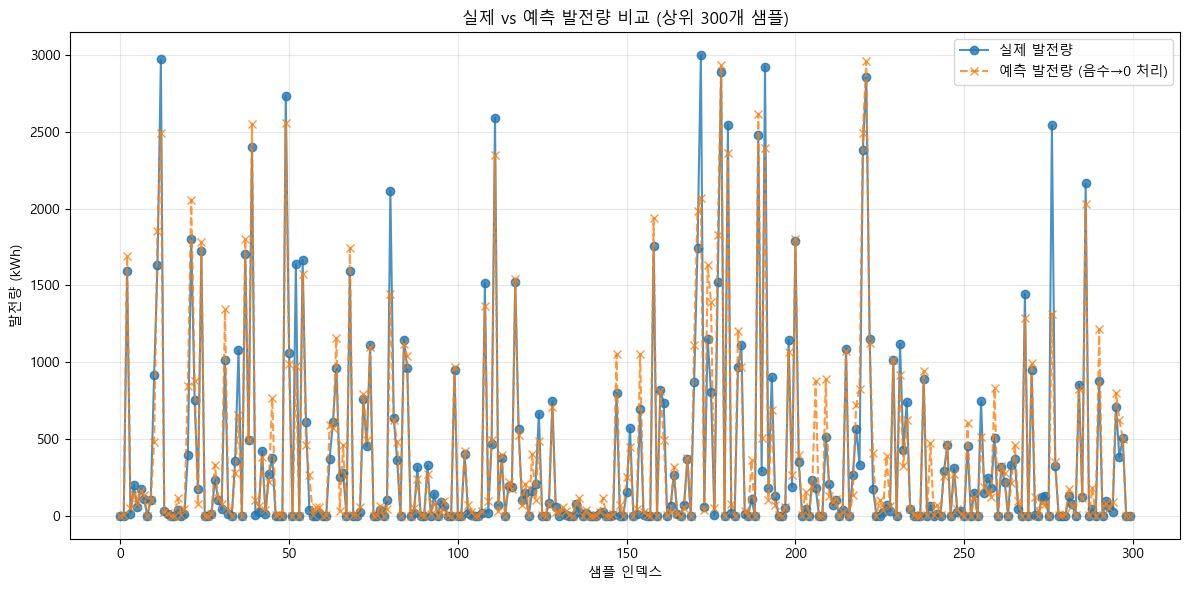


[INFO] SHAP 분석 시작 (샘플 데이터 사용)...


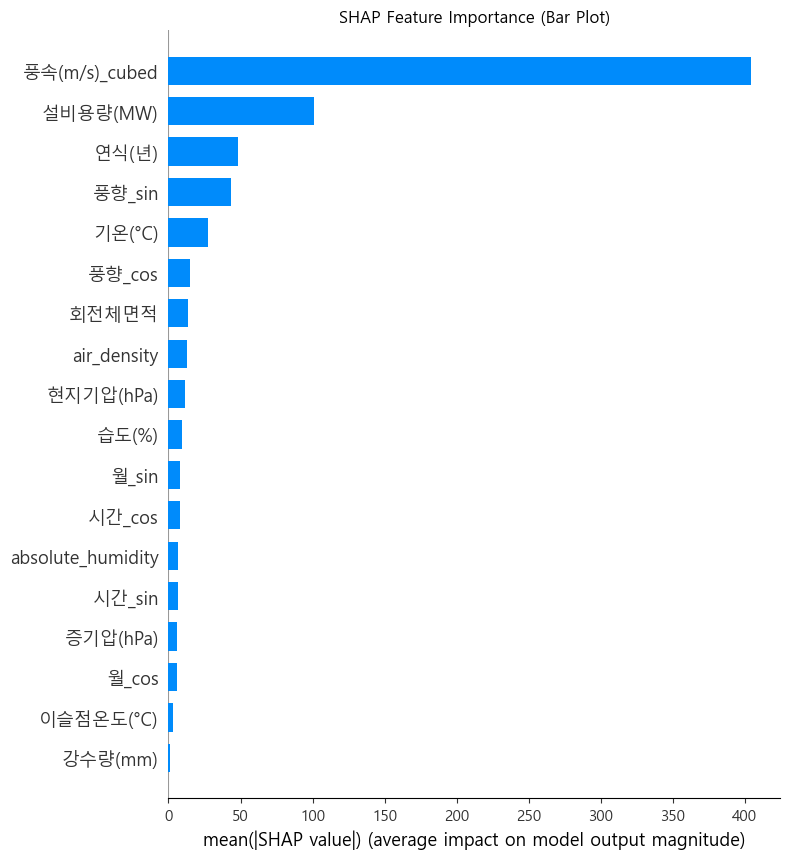

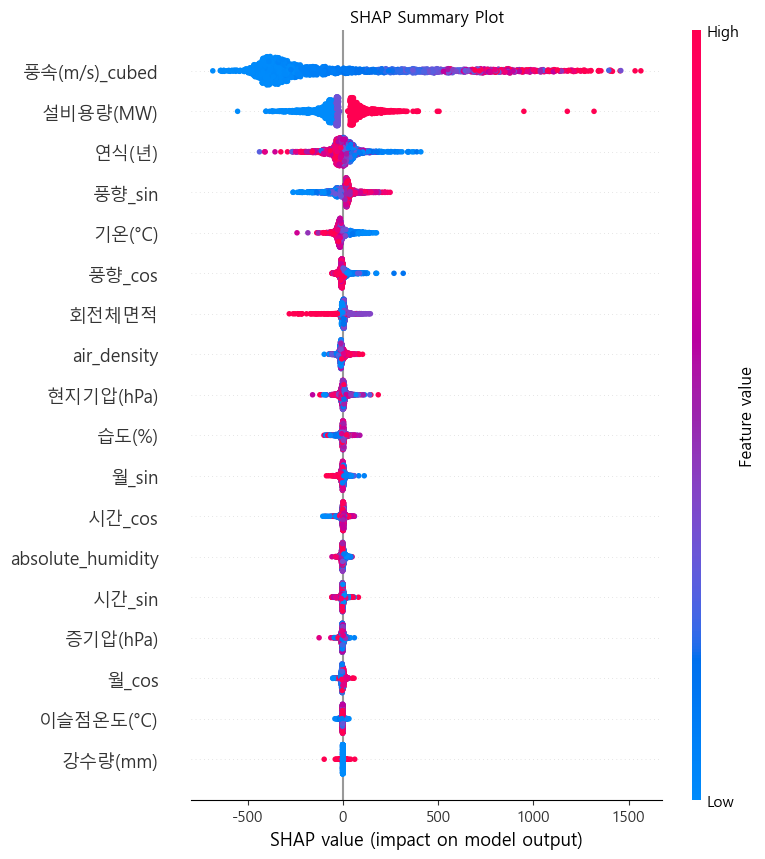

In [4]:
# 1. 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor  # CatBoost에서 XGBoost로 변경
import shap
import warnings
warnings.filterwarnings('ignore')
import os
import joblib

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드
try:
    df = pd.read_csv('../최종사용_데이터/파생변수추가_기상과풍력.csv')
except FileNotFoundError:
    print("[ERROR] '파생변수추가_기상과풍력.csv' 파일을 찾을 수 없습니다.")
    exit()

# 2. 데이터 전처리 (기존과 동일)
# 결측값 제거
if df.isnull().sum().sum() > 0:
    df = df.dropna()

# 파생변수 생성
if '풍속(m/s)' in df.columns:
    df['풍속(m/s)_cubed'] = df['풍속(m/s)'] ** 3
if '블레이드' in df.columns:
    df['회전체면적'] = (df['블레이드'] ** 2) * np.pi

# 3. 특성 및 타겟 변수 설정 (기존과 동일)
features = [
    '설비용량(MW)', '연식(년)', '기온(°C)', '풍속(m/s)_cubed', '습도(%)',
    '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '풍향_sin', '풍향_cos',
    '시간_sin', '시간_cos', '월_sin', '월_cos', '회전체면적',
    'air_density', 'absolute_humidity', '강수량(mm)'
]
available_features = [col for col in features if col in df.columns]
X = df[available_features]
y = df['발전량(kWh)']

print(f"   특성 변수: {len(available_features)}개")
print(f"   타겟 변수: 발전량(kWh) (원본 스케일)")
print(f"   데이터 포인트: {len(X):,}개")

# 3.1. Train/Validation 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. 모델 파라미터 설정 (XGBoost 용으로 변경)
best_params = {
    'n_estimators': 2872,
    'learning_rate': 0.0335762440419045,
    'max_depth': 10,
    'subsample': 0.7272212627300844,
    'colsample_bytree': 0.9254306650281618,
    'tree_method': 'gpu_hist',  # GPU 사용 설정
    'predictor': 'gpu_predictor', # GPU 사용 설정
    'random_state': 42,
    'n_jobs': -1
}
print(f"\n[INFO] 고정 파라미터로 XGBoost 모델 학습 시작: {best_params}")


# 5. K-Fold 교차검증 (nMAE 지표 사용)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
r2_scores = []
print("\n[INFO] K-Fold 교차검증 시작 (평가지표: nMAE, R²)...")

for fold, (train_idx, test_idx) in enumerate(cv.split(X)):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    # 모델 생성 및 학습 (XGBoost로 변경)
    model = XGBRegressor(**best_params)
    model.fit(X_train_fold, y_train_fold, verbose=False)

    # 예측 + 음수 값을 0으로 클리핑
    y_pred = model.predict(X_test_fold)
    y_pred = np.clip(y_pred, 0, None)  # 음수를 0으로 처리

    # nMAE 계산
    mae = mean_absolute_error(y_test_fold, y_pred)
    y_range = y_test_fold.max() - y_test_fold.min()
    nmae = mae / y_range if y_range > 0 else 0
    r2 = r2_score(y_test_fold, y_pred)

    cv_scores.append(nmae)
    r2_scores.append(r2)

    print(f"   Fold {fold+1} nMAE (range): {nmae:.2%}, R²: {r2:.4f}")

print(f"\n[교차검증] 평균 nMAE (range): {np.mean(cv_scores):.2%} ± {np.std(cv_scores):.2%}")
print(f"[교차검증] 평균 R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

# 6. 최종 평가용 모델 학습 및 검증 (Train 데이터만 사용)
print("\n[INFO] 최종 성능 평가를 위한 모델 학습 중...")
eval_model = XGBRegressor(**best_params)

# 간단한 fit (early stopping 없이)
eval_model.fit(X_train, y_train, verbose=False)

# 예측 + 음수 값을 0으로 클리핑
y_pred = eval_model.predict(X_val)
y_pred = np.clip(y_pred, 0, None)  # 음수를 0으로 처리

# 성능 지표 계산
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
y_range = y_val.max() - y_val.min()
nmae = mae / y_range if y_range > 0 else 0
nrmse = rmse / y_range if y_range > 0 else 0
mbe = np.mean(y_pred - y_val)

print(f"  - 결정계수 (R² Score): {r2:.4f}")  # ← 결정계수 추가
print(f"  - 정규화 MAE (nMAE): {nmae:.2%}")
print(f"  - 정규화 RMSE (nRMSE): {nrmse:.2%}")
print(f"  - 평균 편향 오차 (MBE): {mbe:.4f}")
print("="*50 + "\n")

# Feature Importance (평가용 모델 기반)
importance = eval_model.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importance}).sort_values('importance', ascending=False)
print("\n중요 특성:")
for i, (_, row) in enumerate(importance_df.iterrows(), 1):
    print(f"   {i:2d}. {row['feature']}: {row['importance']:.4f}")

# 시각화 (실제값 vs 예측값 비교)
plt.figure(figsize=(12, 6))
plt.plot(y_val.values[:300], label='실제 발전량', alpha=0.8, marker='o', linestyle='-')
plt.plot(y_pred[:300], label='예측 발전량 (음수→0 처리)', alpha=0.8, marker='x', linestyle='--')
plt.xlabel('샘플 인덱스')
plt.ylabel('발전량 (kWh)')
plt.title('실제 vs 예측 발전량 비교 (상위 300개 샘플)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# SHAP 분석으로 모델 해석
print("\n[INFO] SHAP 분석 시작 (샘플 데이터 사용)...")
sample_size = min(2000, len(X_val))
X_val_sample = X_val.sample(n=sample_size, random_state=42)
explainer = shap.TreeExplainer(eval_model)
shap_values = explainer.shap_values(X_val_sample)

# SHAP Bar Plot 시각화
plt.figure()
shap.summary_plot(shap_values, X_val_sample, plot_type='bar', show=False)
plt.title('SHAP Feature Importance (Bar Plot)')
plt.tight_layout()
plt.show()

# SHAP Summary Plot 시각화
plt.figure()
shap.summary_plot(shap_values, X_val_sample, show=False)
plt.title('SHAP Summary Plot')
plt.tight_layout()
plt.show()


In [5]:
# ===========================================
# 전체 데이터로 최종 모델 학습 및 저장
# ===========================================

print("\n[INFO] 전체 데이터로 최종 모델 재학습 중...")
final_model = XGBRegressor(**best_params)  # CatBoost가 아닌 XGBoost로 수정
final_model.fit(X, y, verbose=False)

# ✅ 음수 예측 비율 확인
y_pred_full = final_model.predict(X)
neg_count = np.sum(y_pred_full < 0)
neg_ratio = neg_count / len(y_pred_full)
print(f"🔍 전체 데이터 예측 중 음수 예측: {neg_count}개 ({neg_ratio:.2%})")

# 저장 경로 설정
final_save_path = r'../../3. 최종 예측 모델/data/xgboost_best_model.joblib'  # 파일명도 수정
os.makedirs(os.path.dirname(final_save_path), exist_ok=True)

# 모델 저장
joblib.dump(final_model, final_save_path)
print(f"✅ 전체 데이터 기반 최종 모델이 '{final_save_path}' 위치에 저장되었습니다.")


[INFO] 전체 데이터로 최종 모델 재학습 중...
🔍 전체 데이터 예측 중 음수 예측: 27727개 (16.11%)
✅ 전체 데이터 기반 최종 모델이 '../../3. 최종 예측 모델/data/xgboost_best_model.joblib' 위치에 저장되었습니다.
